# In-Game Predictive Analysis

This notebook details the in-game predictive analysis section of this project. The data has been created in the Data Transformation Advanced notebook and contains a row for each over in the IPL. The data is split into two data frames. One for first innings and one for second innings. The first innings df contains the over, score, and wickets lost. The second innings df contains the over, score, wickets lost and also the corresponding score and wickets lost from the first innings as well as the first innings total. The aim is to predict whether there will be a win for the team batting first at various stages of the game using a number of different algorithms.

This notebook also uses data from the Big Bash t20 league in Australia as validation for the model. For this, the model is trained on the IPL data, and the Big Bash League (BBL) is used as test data to test how transferable this predicter is across countries and competitions. This BBL data contains information from 382 matches between 2010-2021.

The final part of this notebook involves evaluation of this model using data taken from Bet 365 in-game betting odds on the 2022 IPL. For this, in-game scores and live in-game odds were manually annotated into an excel sheet which is then used to simulate theoretical bets. There are a selection of data points - generally speaking one from each innings of each game, although there were time limitations as the 2022 IPL games occur each day and so, some games or innings are not present. These are used to simulate a bet based on the output of the predictive model and using the odds, the final profit/loss is calculated to understand if this model is profitable. This aspect of the project is completely theoretical, no betting accounts were set up, and no bets were placed on any platforms.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
pd.options.mode.chained_assignment = None
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

In [2]:
# load the cleaned matches dataset
matches = pd.read_csv('cleaned_data.csv')

In [3]:
matches

,Unnamed: 0,id,city,date,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,year,country
0,0,335982,Bangalore,2008-04-18,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,2008,India
1,1,335983,Chandigarh,2008-04-19,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,2008,India
2,2,335984,Delhi,2008-04-19,Feroz Shah Kotla,0,Delhi Capitals,Rajasthan Royals,Rajasthan Royals,bat,Delhi Capitals,wickets,9.0,2008,India
3,3,335985,Mumbai,2008-04-20,Wankhede Stadium,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,2008,India
4,4,335986,Kolkata,2008-04-20,Eden Gardens,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,2008,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,810,1216546,Dubai,2020-10-20,Dubai International Cricket Stadium,0,Delhi Capitals,Kings XI Punjab,Delhi Capitals,bat,Kings XI Punjab,wickets,5.0,2020,UAE
776,812,1237177,Dubai,2020-11-05,Dubai International Cricket Stadium,0,Mumbai Indians,Delhi Capitals,Delhi Capitals,field,Mumbai Indians,runs,57.0,2020,UAE
777,813,1237178,Abu Dhabi,2020-11-06,Sheikh Zayed Stadium,0,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,field,Sunrisers Hyderabad,wickets,6.0,2020,UAE
778,814,1237180,Abu Dhabi,2020-11-08,Sheikh Zayed Stadium,0,Delhi Capitals,Sunrisers Hyderabad,Delhi Capitals,bat,Delhi Capitals,runs,17.0,2020,UAE


In [4]:
# load the first/second innings dataset
first_inn = pd.read_csv('first_innings.csv')
second_inn = pd.read_csv('second_innings.csv')

In [5]:
first_inn

,Unnamed: 0,id,inning,over,runs,wickets
0,0,335982,1,1,3,0
1,1,335982,1,2,21,0
2,2,335982,1,3,27,0
3,3,335982,1,4,50,0
4,4,335982,1,5,60,0
...,...,...,...,...,...,...
15500,15500,1237181,1,16,125,4
15501,15501,1237181,1,17,136,4
15502,15502,1237181,1,18,142,5
15503,15503,1237181,1,19,148,5


In [6]:
second_inn

,Unnamed: 0,id,inning,over,runs,wickets,first_innings_runs,first_innings_wkts,first_innings_final_total
0,0,335982,2,1,4,0,3,0,222
1,1,335982,2,2,9,1,21,0,222
2,2,335982,2,3,12,2,27,0,222
3,3,335982,2,4,16,2,50,0,222
4,4,335982,2,5,24,3,60,0,222
...,...,...,...,...,...,...,...,...,...
14752,14752,1237181,2,15,126,2,118,4,156
14753,14753,1237181,2,16,137,2,125,4,156
14754,14754,1237181,2,17,147,3,136,4,156
14755,14755,1237181,2,18,154,4,142,5,156


In [7]:
#ensure the unique ids for each file match up
x = first_inn.id.unique() == matches.id.unique()
for v in x:
    if v == False:
        print('False')
    
print('True')

True


In [8]:
#ensure the unique ids for each file match up
x = second_inn.id.unique() == matches.id.unique()
for v in x:
    if v == False:
        print('False')
    
print('True')

True


In [9]:
first_inn.drop(['Unnamed: 0'], axis=1, inplace=True)
second_inn.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
first_inn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15505 entries, 0 to 15504
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   id       15505 non-null  int64
 1   inning   15505 non-null  int64
 2   over     15505 non-null  int64
 3   runs     15505 non-null  int64
 4   wickets  15505 non-null  int64
dtypes: int64(5)
memory usage: 605.8 KB


In [11]:
second_inn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14757 entries, 0 to 14756
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   id                         14757 non-null  int64
 1   inning                     14757 non-null  int64
 2   over                       14757 non-null  int64
 3   runs                       14757 non-null  int64
 4   wickets                    14757 non-null  int64
 5   first_innings_runs         14757 non-null  int64
 6   first_innings_wkts         14757 non-null  int64
 7   first_innings_final_total  14757 non-null  int64
dtypes: int64(8)
memory usage: 922.4 KB


## Over by over prediction

The data set has been split into first and second innings dataframes and contains 15,505 rows of first innings data and 14,757 rows of second innings data. This represents the 780 games within the IPL split into each over of each game. The label for this data will be `bat_first_win` which will be 1 if the team batting first wins the game and 0 if the team batting second(fielding first) wins the game. This is calculated below. The matches dataset is needed as it contains the winner and toss winner information. This is merged with the in-game info using the match id in both dataframes

In [12]:
#create column for a bat first win
matches['bat_first_win'] = np.where((matches.toss_winner == matches.winner) & (matches.toss_decision == 'bat') | (matches.toss_winner != matches.winner) & (matches.toss_decision != 'bat') , 1, 0)

matches = matches[['id', 'bat_first_win']]
matches

,id,bat_first_win
0,335982,1
1,335983,1
2,335984,0
3,335985,0
4,335986,0
...,...,...
775,1216546,0
776,1237177,1
777,1237178,0
778,1237180,1


In [13]:
merged_1 = pd.merge(first_inn, matches, on='id')

In [14]:
merged_2 = pd.merge(second_inn, matches, on='id')

In [15]:
merged_1

,id,inning,over,runs,wickets,bat_first_win
0,335982,1,1,3,0,1
1,335982,1,2,21,0,1
2,335982,1,3,27,0,1
3,335982,1,4,50,0,1
4,335982,1,5,60,0,1
...,...,...,...,...,...,...
15500,1237181,1,16,125,4,0
15501,1237181,1,17,136,4,0
15502,1237181,1,18,142,5,0
15503,1237181,1,19,148,5,0


In [16]:
merged_2

,id,inning,over,runs,wickets,first_innings_runs,first_innings_wkts,first_innings_final_total,bat_first_win
0,335982,2,1,4,0,3,0,222,1
1,335982,2,2,9,1,21,0,222,1
2,335982,2,3,12,2,27,0,222,1
3,335982,2,4,16,2,50,0,222,1
4,335982,2,5,24,3,60,0,222,1
...,...,...,...,...,...,...,...,...,...
14752,1237181,2,15,126,2,118,4,156,0
14753,1237181,2,16,137,2,125,4,156,0
14754,1237181,2,17,147,3,136,4,156,0
14755,1237181,2,18,154,4,142,5,156,0


## In-game predictions

A function will be created to minimise the reuse of code for each of the algorithms we are to use. The selected algorithms are:

- Random Forest
- Logistic Regression
- Support Vector Machine
- Naive Bayes
- XGBoost

The method for this is to put all the data into their repective overs and then initialise and train the system on a single set of overs without influence from any other overs within the game. This results in a more accurate system. i.e. all of the data for over = 1 is collected and split into train/test. The data is used to train the model before making predictions for all the test data for over = 1. This means that each prediction is calculated using all historic information from the first over. This is done for each over of the game and the results are plotted together in a graph.

In [19]:
def get_over_by_over_accuracy(model_1, model_2, df_1, df_2):
    data_1 = []
    data_2 = []
    sns.set_theme(style="darkgrid",palette="pastel")
    for i in range(1,21):
        temp_1 = df_1[df_1['over']==i]
        temp_2 = df_2[df_2['over']==i]
        y_1 = temp_1.bat_first_win
        y_2 = temp_2.bat_first_win
        temp_1.drop(['bat_first_win', 'id'], axis=1, inplace=True)
        temp_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    
        X_train, X_test, y_train, y_test = train_test_split(temp_1, y_1, test_size=0.2, random_state=42)
        X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(temp_2, y_2, test_size=0.2, random_state=42)
        clf_1 = model_1
        clf_2 = model_2
        clf_1 = clf_1.fit(X_train, y_train)
        clf_2 = clf_2.fit(X_train_2, y_train_2)
        accuracy_1 = clf_1.score(X_test, y_test)
        accuracy_2 = clf_2.score(X_test_2, y_test_2)
        data_1.append([accuracy_1, i])
        data_2.append([accuracy_2, i])
    overs_1 = pd.DataFrame(data_1, columns = ['Accuracy','Over'])
    overs_2 = pd.DataFrame(data_2, columns = ['Accuracy','Over'])
    ax = sns.lineplot(data=overs_1, x='Over', y='Accuracy', label='First Innings')
    ax_2 = sns.lineplot(data=overs_2, x='Over', y='Accuracy', label='Second Innings')
    #ax.set_title('In-Game Prediction Accuracy',size=20,fontweight="bold")
    ax.set_xticks(overs_1.Over.values)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    ax.figure.savefig('in_game_live_pred_advanced.png',dpi=300, bbox_inches = "tight")
    #ax.legend(loc='upper left')
    

## Random Forest

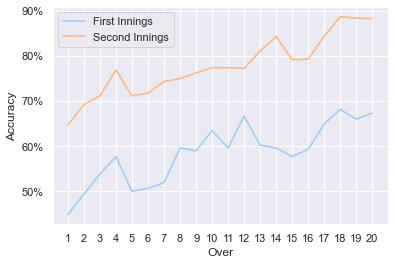

In [20]:
get_over_by_over_accuracy(RandomForestClassifier(max_depth=4, random_state=0),RandomForestClassifier(max_depth=4, random_state=0), merged_1, merged_2)

## Naive Bayes

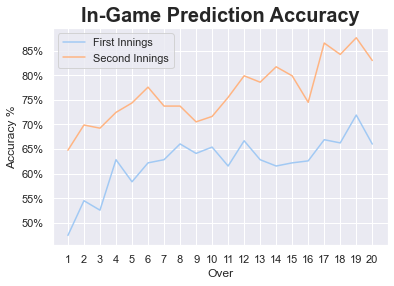

In [19]:
get_over_by_over_accuracy(GaussianNB(),GaussianNB(), merged_1, merged_2)

## Logistic Regression

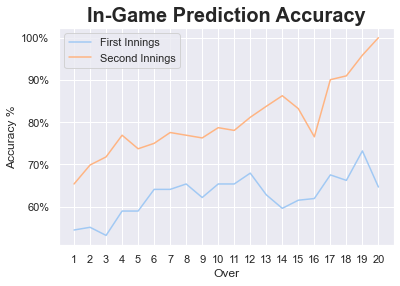

In [20]:
get_over_by_over_accuracy(LogisticRegression(random_state=0, max_iter=3000), LogisticRegression(random_state=0, max_iter=3000), merged_1, merged_2)

## Support Vector machine

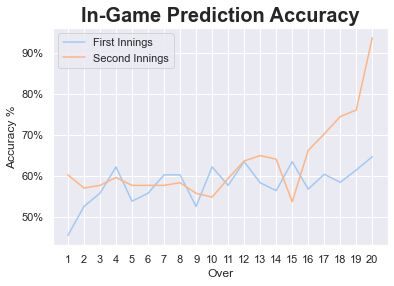

In [21]:
get_over_by_over_accuracy(SVC(gamma='auto'),SVC(gamma='auto'), merged_1, merged_2)

## XGBoost

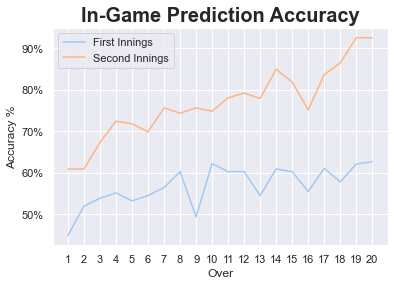

In [22]:
get_over_by_over_accuracy(xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), merged_1, merged_2)

## Results

All algorithms other than the Support Vector Machine show good predictive capabilities with this dataset. The random forest has been the most successful across a number of tasks and it again performs well. The accuracy across algorithms varies from 50-70% in the first innings with a steady improvement as the game goes on. This accuracy is between 60-95% in the second innings with Logistic regression reaching 80% accuracy in the 9th over of the second innings.

Random Forest shows a peak at 4 overs in both innings, 12 overs in the first innings and 14 overs in the second innings. The questions the prior belief about whether the 6 over powerplay was as important a factor in determining the winner. There is also a reduction in accuracy for the last couple of overs across both innings. This may be due to the model allowing for too much importance on wickets which can often become less important as the innings comes to a close.

This model will now be validated using the BBL data to see if this performance is the same across leagues/countries.

## Alternative method

To determine whether the over by over method is accurate, the model is trained on the data all at once (without selecting each over one by one) to compare this with the previous method.

## Random Forest - trained on all data

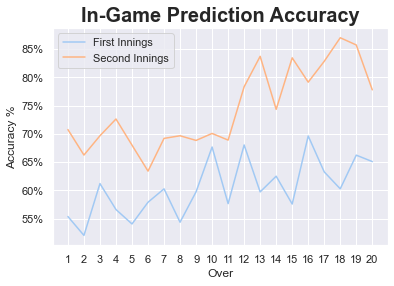

In [23]:
data_1 = []
data_2 = []
sns.set_theme(style="darkgrid",palette="pastel")

train, test = train_test_split(merged_1, test_size=0.2, random_state=42)
train_2, test_2 = train_test_split(merged_2, test_size=0.2, random_state=42)

clf_1 = RandomForestClassifier(max_depth=4, random_state=0)
clf_2 = RandomForestClassifier(max_depth=4, random_state=0)

X_train = train
y_train = train.bat_first_win
X_train.drop(['bat_first_win', 'id'], axis=1, inplace=True)
X_train_2 = train_2
y_train_2 = train_2.bat_first_win
X_train_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)

clf_1 = clf_1.fit(X_train, y_train)
clf_2 = clf_2.fit(X_train_2, y_train_2)

for i in range(1,21):
    X_test_over = test[test.over==i]
    X_test_over_2 = test_2[test_2.over==i]
    bbl_y_1 = X_test_over.bat_first_win
    bbl_y_2 = X_test_over_2.bat_first_win
    X_test_over.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    X_test_over_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    accuracy_1 = clf_1.score(X_test_over, bbl_y_1)
    accuracy_2 = clf_2.score(X_test_over_2, bbl_y_2)
    data_1.append([accuracy_1, i])
    data_2.append([accuracy_2, i])
overs_1 = pd.DataFrame(data_1, columns = ['Accuracy %','Over'])
overs_2 = pd.DataFrame(data_2, columns = ['Accuracy %','Over'])
ax = sns.lineplot(data=overs_1, x='Over', y='Accuracy %', label='First Innings')
ax_2 = sns.lineplot(data=overs_2, x='Over', y='Accuracy %', label='Second Innings')
ax.set_title('In-Game Prediction Accuracy',size=20,fontweight="bold")
ax.set_xticks(overs_1.Over.values)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
#ax.figure.savefig('in_game_live_pred_advanced.png',dpi=300, bbox_inches = "tight")
#ax.legend(loc='upper left')

## Naive Bayes - trained on all data

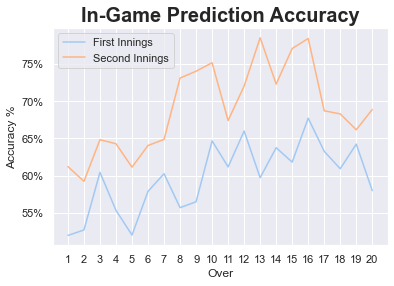

In [24]:
data_1 = []
data_2 = []
sns.set_theme(style="darkgrid",palette="pastel")

train, test = train_test_split(merged_1, test_size=0.2, random_state=42)
train_2, test_2 = train_test_split(merged_2, test_size=0.2, random_state=42)

clf_1 = GaussianNB()
clf_2 = GaussianNB()

X_train = train
y_train = train.bat_first_win
X_train.drop(['bat_first_win', 'id'], axis=1, inplace=True)
X_train_2 = train_2
y_train_2 = train_2.bat_first_win
X_train_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)

clf_1 = clf_1.fit(X_train, y_train)
clf_2 = clf_2.fit(X_train_2, y_train_2)

for i in range(1,21):
    X_test_over = test[test.over==i]
    X_test_over_2 = test_2[test_2.over==i]
    bbl_y_1 = X_test_over.bat_first_win
    bbl_y_2 = X_test_over_2.bat_first_win
    X_test_over.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    X_test_over_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    accuracy_1 = clf_1.score(X_test_over, bbl_y_1)
    accuracy_2 = clf_2.score(X_test_over_2, bbl_y_2)
    data_1.append([accuracy_1, i])
    data_2.append([accuracy_2, i])
overs_1 = pd.DataFrame(data_1, columns = ['Accuracy %','Over'])
overs_2 = pd.DataFrame(data_2, columns = ['Accuracy %','Over'])
ax = sns.lineplot(data=overs_1, x='Over', y='Accuracy %', label='First Innings')
ax_2 = sns.lineplot(data=overs_2, x='Over', y='Accuracy %', label='Second Innings')
ax.set_title('In-Game Prediction Accuracy',size=20,fontweight="bold")
ax.set_xticks(overs_1.Over.values)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
#ax.figure.savefig('in_game_live_pred_advanced.png',dpi=300, bbox_inches = "tight")
#ax.legend(loc='upper left')

## Logistic Regression - trained on all data

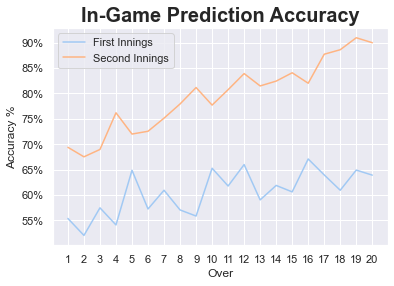

In [25]:
data_1 = []
data_2 = []
sns.set_theme(style="darkgrid",palette="pastel")

train, test = train_test_split(merged_1, test_size=0.2, random_state=42)
train_2, test_2 = train_test_split(merged_2, test_size=0.2, random_state=42)

clf_1 = LogisticRegression(random_state=0, max_iter=3000)
clf_2 = LogisticRegression(random_state=0, max_iter=3000)

X_train = train
y_train = train.bat_first_win
X_train.drop(['bat_first_win', 'id'], axis=1, inplace=True)
X_train_2 = train_2
y_train_2 = train_2.bat_first_win
X_train_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)

clf_1 = clf_1.fit(X_train, y_train)
clf_2 = clf_2.fit(X_train_2, y_train_2)

for i in range(1,21):
    X_test_over = test[test.over==i]
    X_test_over_2 = test_2[test_2.over==i]
    bbl_y_1 = X_test_over.bat_first_win
    bbl_y_2 = X_test_over_2.bat_first_win
    X_test_over.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    X_test_over_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    accuracy_1 = clf_1.score(X_test_over, bbl_y_1)
    accuracy_2 = clf_2.score(X_test_over_2, bbl_y_2)
    data_1.append([accuracy_1, i])
    data_2.append([accuracy_2, i])
overs_1 = pd.DataFrame(data_1, columns = ['Accuracy %','Over'])
overs_2 = pd.DataFrame(data_2, columns = ['Accuracy %','Over'])
ax = sns.lineplot(data=overs_1, x='Over', y='Accuracy %', label='First Innings')
ax_2 = sns.lineplot(data=overs_2, x='Over', y='Accuracy %', label='Second Innings')
ax.set_title('In-Game Prediction Accuracy',size=20,fontweight="bold")
ax.set_xticks(overs_1.Over.values)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
#ax.figure.savefig('in_game_live_pred_advanced.png',dpi=300, bbox_inches = "tight")
#ax.legend(loc='upper left')

## Support Vector Machine - trained on all data

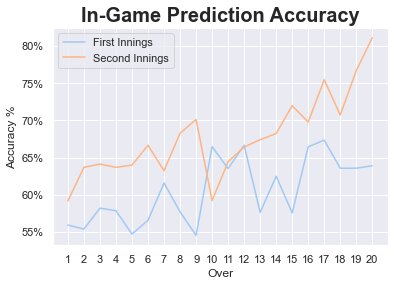

In [26]:
data_1 = []
data_2 = []
sns.set_theme(style="darkgrid",palette="pastel")

train, test = train_test_split(merged_1, test_size=0.2, random_state=42)
train_2, test_2 = train_test_split(merged_2, test_size=0.2, random_state=42)

clf_1 = SVC(gamma='auto')
clf_2 = SVC(gamma='auto')

X_train = train
y_train = train.bat_first_win
X_train.drop(['bat_first_win', 'id'], axis=1, inplace=True)
X_train_2 = train_2
y_train_2 = train_2.bat_first_win
X_train_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)

clf_1 = clf_1.fit(X_train, y_train)
clf_2 = clf_2.fit(X_train_2, y_train_2)

for i in range(1,21):
    X_test_over = test[test.over==i]
    X_test_over_2 = test_2[test_2.over==i]
    bbl_y_1 = X_test_over.bat_first_win
    bbl_y_2 = X_test_over_2.bat_first_win
    X_test_over.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    X_test_over_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    accuracy_1 = clf_1.score(X_test_over, bbl_y_1)
    accuracy_2 = clf_2.score(X_test_over_2, bbl_y_2)
    data_1.append([accuracy_1, i])
    data_2.append([accuracy_2, i])
overs_1 = pd.DataFrame(data_1, columns = ['Accuracy %','Over'])
overs_2 = pd.DataFrame(data_2, columns = ['Accuracy %','Over'])
ax = sns.lineplot(data=overs_1, x='Over', y='Accuracy %', label='First Innings')
ax_2 = sns.lineplot(data=overs_2, x='Over', y='Accuracy %', label='Second Innings')
ax.set_title('In-Game Prediction Accuracy',size=20,fontweight="bold")
ax.set_xticks(overs_1.Over.values)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
#ax.figure.savefig('in_game_live_pred_advanced.png',dpi=300, bbox_inches = "tight")
#ax.legend(loc='upper left')

## XGBoost - trained on all data

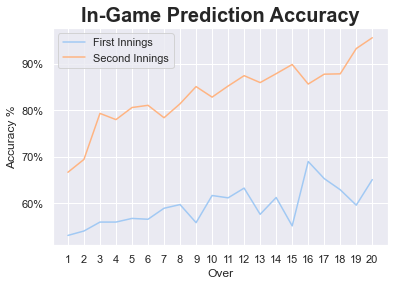

In [27]:
data_1 = []
data_2 = []
sns.set_theme(style="darkgrid",palette="pastel")

train, test = train_test_split(merged_1, test_size=0.2, random_state=42)
train_2, test_2 = train_test_split(merged_2, test_size=0.2, random_state=42)

clf_1 = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
clf_2 = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

X_train = train
y_train = train.bat_first_win
X_train.drop(['bat_first_win', 'id'], axis=1, inplace=True)
X_train_2 = train_2
y_train_2 = train_2.bat_first_win
X_train_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)

clf_1 = clf_1.fit(X_train, y_train)
clf_2 = clf_2.fit(X_train_2, y_train_2)

for i in range(1,21):
    X_test_over = test[test.over==i]
    X_test_over_2 = test_2[test_2.over==i]
    bbl_y_1 = X_test_over.bat_first_win
    bbl_y_2 = X_test_over_2.bat_first_win
    X_test_over.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    X_test_over_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)
    accuracy_1 = clf_1.score(X_test_over, bbl_y_1)
    accuracy_2 = clf_2.score(X_test_over_2, bbl_y_2)
    data_1.append([accuracy_1, i])
    data_2.append([accuracy_2, i])
overs_1 = pd.DataFrame(data_1, columns = ['Accuracy %','Over'])
overs_2 = pd.DataFrame(data_2, columns = ['Accuracy %','Over'])
ax = sns.lineplot(data=overs_1, x='Over', y='Accuracy %', label='First Innings')
ax_2 = sns.lineplot(data=overs_2, x='Over', y='Accuracy %', label='Second Innings')
ax.set_title('In-Game Prediction Accuracy',size=20,fontweight="bold")
ax.set_xticks(overs_1.Over.values)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
#ax.figure.savefig('in_game_live_pred_advanced.png',dpi=300, bbox_inches = "tight")
#ax.legend(loc='upper left')

## Results 

The XGBoost and support vector machine show a small improvement with this method although the overall results favour the over by over approach. Most notable is the XGBoost which reaches 79% in the 3rd over of the second innings and increases from there.

The over by over model will now be validated using the BBL data to see if this performance is the same across leagues/countries.

In [28]:
#import bbl data
bbl_first_inn = pd.read_csv('bbl_first_innings.csv')
bbl_second_inn = pd.read_csv('bbl_second_innings.csv') 
bbl_match = pd.read_csv('bbl_matches.csv')

In [29]:
len(bbl_match.id.unique())

414

In [30]:
# remove no result games
no_result = bbl_match[bbl_match.result.isnull()]
no_result.id.value_counts()
no = no_result.id.unique()

# find D/L affected matches by id and create an array with these id's
dl_result = bbl_match[bbl_match.method=='D/L']
dl_result.id.value_counts()
dl = dl_result.id.unique()

# find tied matches by id and create an array with these id's
tie_result = bbl_match[bbl_match.result=='tie']
tie_result.id.value_counts()
tie = tie_result.id.unique()

# edit the matches dataframe to remove D/L affected matches and tied matches
bbl_match = bbl_match[~bbl_match.id.isin(dl)]
bbl_match = bbl_match[~bbl_match.id.isin(tie)]
bbl_match = bbl_match[~bbl_match.id.isin(no)]

In [31]:
len(bbl_match.id.value_counts())

382

In [32]:
len(bbl_second_inn.id.value_counts())

382

The data set has been reduced to 382 games when all DL, tied, and no result games are removed.

In [33]:
bbl_first_inn

,Unnamed: 0,id,inning,over,runs,wickets
0,0,524915,1,1,4,0
1,1,524915,1,2,12,0
2,2,524915,1,3,13,0
3,3,524915,1,4,18,0
4,4,524915,1,5,28,0
...,...,...,...,...,...,...
7599,7599,1226885,1,16,110,6
7600,7600,1226885,1,17,123,6
7601,7601,1226885,1,18,134,6
7602,7602,1226885,1,19,144,8


In [34]:
bbl_first_inn.drop(['Unnamed: 0'], axis=1, inplace=True)
bbl_second_inn.drop(['Unnamed: 0'], axis=1, inplace=True)

In [35]:
#create column for a bat first win
bbl_match['bat_first_win'] = np.where((bbl_match.toss_winner == bbl_match.winner) & (bbl_match.toss_decision == 'bat') | (bbl_match.toss_winner != bbl_match.winner) & (bbl_match.toss_decision != 'bat') , 1, 0)

bbl_match = bbl_match[['id', 'bat_first_win']]
bbl_match

,id,bat_first_win
0,524915,0
1,524916,0
2,524917,1
3,524918,1
4,524919,1
...,...,...
408,1226881,1
409,1226882,1
410,1226883,0
411,1226884,0


In [36]:
#merged datatsets to get bat_first_win for each game
bbl_merged_1 = pd.merge(bbl_first_inn, bbl_match, on='id')
bbl_merged_2 = pd.merge(bbl_second_inn, bbl_match, on='id')

bbl_merged_1

,id,inning,over,runs,wickets,bat_first_win
0,524915,1,1,4,0,0
1,524915,1,2,12,0,0
2,524915,1,3,13,0,0
3,524915,1,4,18,0,0
4,524915,1,5,28,0,0
...,...,...,...,...,...,...
7599,1226885,1,16,110,6,0
7600,1226885,1,17,123,6,0
7601,1226885,1,18,134,6,0
7602,1226885,1,19,144,8,0


In [37]:
bbl_merged_2

,id,inning,over,runs,wickets,first_innings_runs,first_innings_wkts,first_innings_final_total,bat_first_win
0,524915,2,1,4,0,4,0,139,0
1,524915,2,2,10,0,12,0,139,0
2,524915,2,3,13,0,13,0,139,0
3,524915,2,4,30,0,18,0,139,0
4,524915,2,5,39,1,28,0,139,0
...,...,...,...,...,...,...,...,...,...
7131,1226885,2,16,124,3,110,6,158,0
7132,1226885,2,17,138,3,123,6,158,0
7133,1226885,2,18,147,3,134,6,158,0
7134,1226885,2,19,158,3,144,8,158,0


## Random Forest - BBL

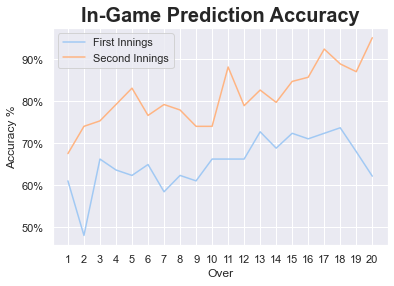

In [38]:
get_over_by_over_accuracy(RandomForestClassifier(max_depth=4, random_state=0),RandomForestClassifier(max_depth=4, random_state=0), bbl_merged_1, bbl_merged_2)

## Results

The BBL results shows the model performs well across other datasets from other leagues/countries. This further validates that the model is applicable across t20 cricket not just within India.

## Evaluation

This in game predictive model is now evaluated using data from the 2022 IPL and measured against betting odds from bet365 website. For each game a single unit is (theoretically) bet on the predicted winner during each innings from each game. The betting data has been manually notated at random time intervals in the game. This should allow for a good measurement of the accuracy of the predictive model and rating it on the much more complicated and complex models used to create betting odds from betting companies.

In [39]:
#import IPL betting data
ipl_22 = pd.read_excel('IPL_betting_odds.xlsx', sheet_name='in-game')
merged_1 = pd.merge(first_inn, matches, on='id')
merged_2 = pd.merge(second_inn, matches, on='id')

In [40]:
ipl_22

,id,inning,over,runs,wickets,bat_first_win,odds_bat_first_win,odds_bat_second_win,team1,team2,first_innings_runs,first_innings_wkts,first_innings_final_total
0,1,1,6,35,2,0,2.75,1.440,Chennai Super Kings,Kolkata Knight Riders,NaN,NaN,NaN
1,1,2,6,43,0,0,17.00,1.025,Chennai Super Kings,Kolkata Knight Riders,35.0,2.0,131.0
2,2,1,6,53,0,0,1.44,2.750,Delhi Capitals,Mumbai Indians,NaN,NaN,NaN
3,2,2,6,46,3,0,1.22,4.330,Delhi Capitals,Mumbai Indians,53.0,0.0,177.0
4,3,1,6,41,0,0,1.90,1.900,Punjab Kings,Royal Challengers Bangalore,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,34,2,4,35,0,1,1.28,3.750,Delhi Capitals,Rajasthan Royals,26.0,0.0,222.0
58,37,1,13,103,3,1,2.00,1.800,Lucknow Super Giants,Mumbai Indians,NaN,NaN,NaN
59,37,2,8,54,1,1,1.90,1.900,Lucknow Super Giants,Mumbai Indians,45.0,1.0,168.0
60,38,1,7,43,1,1,1.90,1.900,Punjab Kings,Chennai Super Kings,NaN,NaN,NaN


In [41]:
ipl_22 = ipl_22[0:62]
ipl_22

,id,inning,over,runs,wickets,bat_first_win,odds_bat_first_win,odds_bat_second_win,team1,team2,first_innings_runs,first_innings_wkts,first_innings_final_total
0,1,1,6,35,2,0,2.75,1.440,Chennai Super Kings,Kolkata Knight Riders,NaN,NaN,NaN
1,1,2,6,43,0,0,17.00,1.025,Chennai Super Kings,Kolkata Knight Riders,35.0,2.0,131.0
2,2,1,6,53,0,0,1.44,2.750,Delhi Capitals,Mumbai Indians,NaN,NaN,NaN
3,2,2,6,46,3,0,1.22,4.330,Delhi Capitals,Mumbai Indians,53.0,0.0,177.0
4,3,1,6,41,0,0,1.90,1.900,Punjab Kings,Royal Challengers Bangalore,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,34,2,4,35,0,1,1.28,3.750,Delhi Capitals,Rajasthan Royals,26.0,0.0,222.0
58,37,1,13,103,3,1,2.00,1.800,Lucknow Super Giants,Mumbai Indians,NaN,NaN,NaN
59,37,2,8,54,1,1,1.90,1.900,Lucknow Super Giants,Mumbai Indians,45.0,1.0,168.0
60,38,1,7,43,1,1,1.90,1.900,Punjab Kings,Chennai Super Kings,NaN,NaN,NaN


In [42]:
ipl_22_first_inning = ipl_22[ipl_22.inning==1]
ipl_22_second_inning = ipl_22[ipl_22.inning==2]

In [43]:
first_inning_odds_bat_first_win = np.array(ipl_22_first_inning.odds_bat_first_win)
second_inning_odds_bat_first_win = np.array(ipl_22_second_inning.odds_bat_first_win)
first_inning_odds_bat_second_win = np.array(ipl_22_first_inning.odds_bat_second_win)
second_inning_odds_bat_second_win = np.array(ipl_22_second_inning.odds_bat_second_win)
first_inning_bat_first_win = np.array(ipl_22_first_inning.bat_first_win)
second_inning_bat_first_win = np.array(ipl_22_second_inning.bat_first_win)

In [44]:
ipl_22_first_inning.drop(columns=['id', 'bat_first_win', 'team1', 'team2', 'odds_bat_first_win', 'odds_bat_second_win'], axis=1, inplace=True)
ipl_22_second_inning.drop(columns=['id', 'bat_first_win', 'team1', 'team2', 'odds_bat_first_win', 'odds_bat_second_win'], axis=1, inplace=True)

In [45]:
ipl_22_first_inning.drop(['first_innings_runs', 'first_innings_wkts', 'first_innings_final_total'], axis=1, inplace=True)


In [46]:
ipl_22_first_inning

,inning,over,runs,wickets
0,1,6,35,2
2,1,6,53,0
4,1,6,41,0
6,1,12,63,4
8,1,6,58,0
10,1,6,44,3
12,1,6,73,1
14,1,6,48,2
16,1,9,58,2
18,1,9,48,3


In [47]:
ipl_22_second_inning

,inning,over,runs,wickets,first_innings_runs,first_innings_wkts,first_innings_final_total
1,2,6,43,0,35.0,2.0,131.0
3,2,6,46,3,53.0,0.0,177.0
5,2,10,97,1,70.0,1.0,205.0
7,2,6,44,2,32.0,4.0,158.0
9,2,6,14,3,58.0,0.0,210.0
11,2,7,40,3,46.0,4.0,128.0
13,2,6,55,0,73.0,1.0,210.0
15,2,6,50,2,48.0,2.0,193.0
17,2,11,86,3,75.0,2.0,171.0
19,2,9,77,2,48.0,3.0,169.0


In [48]:
# train random forest
clf_1 = RandomForestClassifier(max_depth=4, random_state=0)
clf_2 = RandomForestClassifier(max_depth=4, random_state=0)
y_1 = merged_1.bat_first_win
y_2 = merged_2.bat_first_win
merged_1.drop(['bat_first_win', 'id'], axis=1, inplace=True)
merged_2.drop(['bat_first_win', 'id'], axis=1, inplace=True)

# train model on historic IPL data
clf_1 = clf_1.fit(merged_1, y_1)
clf_2 = clf_2.fit(merged_2, y_2)

# make predictions using new IPL data from 2022
y_pred_1 = clf_1.predict(ipl_22_first_inning)
y_pred_2 = clf_2.predict(ipl_22_second_inning)

In [49]:
merged_1

,inning,over,runs,wickets
0,1,1,3,0
1,1,2,21,0
2,1,3,27,0
3,1,4,50,0
4,1,5,60,0
...,...,...,...,...
15500,1,16,125,4
15501,1,17,136,4
15502,1,18,142,5
15503,1,19,148,5


In [50]:
merged_2

,inning,over,runs,wickets,first_innings_runs,first_innings_wkts,first_innings_final_total
0,2,1,4,0,3,0,222
1,2,2,9,1,21,0,222
2,2,3,12,2,27,0,222
3,2,4,16,2,50,0,222
4,2,5,24,3,60,0,222
...,...,...,...,...,...,...,...
14752,2,15,126,2,118,4,156
14753,2,16,137,2,125,4,156
14754,2,17,147,3,136,4,156
14755,2,18,154,4,142,5,156


In [51]:
# first innings predictions
y_pred_1

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0])

In [52]:
# first innings results
first_inning_bat_first_win

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1])

In [53]:
# second innings predictions
y_pred_2

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1])

In [54]:
# second innings results
second_inning_bat_first_win

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1])

In [55]:
# create comparison between betting companies odds and the predictive model
# calcualte stake - bet, inning1 profit, inning2 profit and total profit/loss

cumulative_stakes = 0
innings_1_profit = 0
innings_2_profit = 0
correct_bets = 0
i = 0
while i < len(first_inning_bat_first_win):
    if y_pred_1[i] == first_inning_bat_first_win[i]:
        correct_bets += 1
        if y_pred_1[i] == 0:
            innings_1_profit += (1*first_inning_odds_bat_second_win[i]) - 1
        else:
            innings_1_profit += (1*first_inning_odds_bat_first_win[i]) - 1
    else:
        innings_1_profit = innings_1_profit - 1
    cumulative_stakes += 1
    i += 1
    
j = 0
while j < len(second_inning_bat_first_win):
    if y_pred_2[j] == second_inning_bat_first_win[j]:
        correct_bets += 1
        if y_pred_2[j] == 0:
            innings_2_profit += (1*second_inning_odds_bat_second_win[j]) - 1
        else:
            innings_2_profit += (1*second_inning_odds_bat_first_win[j]) - 1
    else:
        innings_2_profit = innings_2_profit - 1
    j += 1
    # a stake for each inning
    cumulative_stakes += 1
    
total_profit = innings_1_profit+innings_2_profit
print('Cumulative stakes: ' + str(cumulative_stakes) + '\nInnings 1 Profit: ' + str(round(innings_1_profit, 2)) + '\nInnings 2 Profit: ' + str(round(innings_2_profit, 2)) + '\nTotal Profit: ' + str(round(total_profit, 2)))
print(str(round(total_profit/cumulative_stakes, 2)*100)+'% Return on Investment from ' + str(correct_bets) + ' correct bets out of ' + str(cumulative_stakes) + ' - Accuracy: ' + str(round(correct_bets/cumulative_stakes, 2)*100) + '%')

Cumulative stakes: 62
Innings 1 Profit: 10.09
Innings 2 Profit: 6.82
Total Profit: 16.91
27.0% Return on Investment from 48 correct bets out of 62 - Accuracy: 77.0%


## Conclusion

The in-game predictive model has shown impressive results across IPL and BBL data. It has also performed well vs the live in-game betting odds with a decent return of 27% on the original investment due to correctly predicting 48 out of 62 game outcomes. This is across a relatively small sample size but shows that the model has some element of predictive capability and is thus far profitable.

The random forest algorithm returned the best results for this task.
